In [71]:
import requests
import pandas as pd
import configparser
import time
import seaborn as sns
import matplotlib as mpl

/Users/jkharada/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [3]:
parser = configparser.ConfigParser()
_ = parser.read('snorkel.cfg')
ncei_auth_key = parser.get('NOAA_NCDC', 'token')

In [4]:
## Get Maui weatherstations
headers = {'token': ncei_auth_key}
params = {
#    'dataset': 'daily-summaries',
#    'extent': (20.544036, -155.901725, 21.062098, -156.733017),
    'locationid': 'FIPS:15',
#    'locationcategoryid': 'ST',
    'startdate': '2016-06-04',
    'enddate': '2023-04-06',
    'limit': 400
}
stations = requests.get('https://www.ncei.noaa.gov/cdo-web/api/v2/stations/', params=params, headers=headers).json()

In [5]:
df_hi_stations = pd.json_normalize(stations['results'])
df_maui_stations = df_hi_stations.loc[(df_hi_stations['latitude'] < 21.062098) & (df_hi_stations['latitude'] > 20.544036)
                  & (df_hi_stations['longitude'] < -155.901725) & (df_hi_stations['longitude'] > -156.733017)]

In [7]:
maui_station_ids = df_maui_stations['id'].tolist()

In [10]:
stations = [ station.split(':')[1] for station in maui_station_ids ]
stations.pop()
stations.pop()

'22516'

In [12]:
params = {
    'dataset': 'daily-summaries',
#    'bbox': '20.544036,-155.901725,21.062098,-156.733017',
#    'locationid': 'ZIP:28801',
    'stations': ','.join(stations),
    'startDate': '2016-06-01',
    'endDate': '2023-04-06',
#    'locationcategoryid': 'ST',
    'limit': 40,
    'format': 'json',
    'units': 'standard',
    'includeStationName': 'true',
}
weather_data = requests.get('https://www.ncei.noaa.gov/access/services/data/v1', params=params, headers=headers).json()

In [13]:
df_weather = pd.json_normalize(weather_data)

In [15]:
"""
For each weather station, drop columns which have all na values, 
drop name, station columns, and rename columns to have station name in them. 
Then add them to the weather dataframe. 

index = pd.date_range('2016-06-01', '2023-04-06', freq='D')
"""
df_weather_formatted = pd.DataFrame()

for station in stations:
    temp = df_weather.query("STATION == @station").dropna(axis=1, how='all')
    cols = temp.columns
    wt_cols = { str(col): 0 for col in cols if 'WT' in col }
    temp.fillna(wt_cols, inplace=True)
    temp.drop(['STATION','NAME'], axis=1, inplace=True)
    temp.set_index('DATE', inplace=True)
    temp.rename(lambda x: station + '_' + x, axis='columns', inplace=True)
    temp.index.name = None
    df_weather_formatted = pd.concat([df_weather_formatted, temp], axis=1, join='outer')
#    print(df_weather_cleaned)
    
df_weather_formatted.sort_index(inplace = True)

In [74]:
data_missing = df_weather_formatted.isnull().mean() * 100
#with pd.option_context('display.max_rows', None):
#    display(data_missing.sort_values())

features = list(data_missing[data_missing < 20].index)

df_weather_features = df_weather_formatted[features]

In [52]:
df = pd.DataFrame({'col1': [1, 2], 'col2': [3, 4]})
print(df)
df.mean()

   col1  col2
0     1     3
1     2     4


col1    1.5
col2    3.5
dtype: float64

In [66]:
## Fill missing data values with median of column

for col in df_weather_features:
    df_weather_features[col].fillna(df_weather_features[col].median(), inplace=True)
    

/var/folders/fh/1wkn526x7pzdr03mqh7m7vnm0000gn/T/ipykernel_5278/4187098800.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather_features[col].fillna(df_weather_features[col].median(), inplace=True)
/var/folders/fh/1wkn526x7pzdr03mqh7m7vnm0000gn/T/ipykernel_5278/4187098800.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather_features[col].fillna(df_weather_features[col].median(), inplace=True)
/var/folders/fh/1wkn526x7pzdr03mqh7m7vnm0000gn/T/ipykernel_5278/4187098800.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation:

,US1HIMI0001_PRCP,USC00515000_PRCP,USC00515000_TMAX,USC00515000_TMIN,USC00515000_TOBS,USC00515004_PRCP,USC00515004_TMAX,USC00515004_TMIN,USC00515004_TOBS,USC00515715_PRCP,...,USW00022516_TMIN,USW00022516_TAVG,USW00022516_WSF2,USW00022516_WSF5,USW00022516_WDF2,USW00022516_AWND,USW00022516_WDF5,USW00022516_WT01,USW00022516_WT08,USW00022516_WT03
2016-06-01,0.93,0.41,68,58,61,0.18,71,57,63,0.30,...,70,74,21.0,25.1,40,10.29,40,1,0,0
2016-06-02,0.16,0.02,71,58,62,0.00,71,56,63,0.02,...,71,75,21.9,23.9,40,9.84,30,1,1,0
2016-06-03,0.05,0.00,71,57,62,0.00,72,56,61,0.01,...,68,76,16.1,21.0,10,8.95,360,0,0,0
2016-06-04,0.00,0.04,72,58,63,0.00,71,58,64,0.05,...,68,75,14.1,19.9,20,5.59,30,1,0,0
2016-06-05,0.00,0.05,67,58,66,0.00,71,58,62,0.00,...,68,77,18.1,23.0,30,8.28,20,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-02,0.00,0.42,73.0,56.0,60.0,0.0,72.0,55.0,59.0,0.02,...,66,75,23.0,31.1,50,8.72,60,1,0,0
2023-04-03,1.28,0.52,69,55,60,0.0,72.0,55.0,59.0,0.02,...,68,73,23.9,29.1,30,12.30,30,0,0,0
2023-04-04,0.14,0.02,68,56,57,0.0,72.0,55.0,59.0,0.02,...,64,74,29.1,35.1,40,13.42,40,0,0,0
2023-04-05,0.00,0.00,70,55,56,0.0,72.0,55.0,59.0,0.02,...,65,75,31.1,36.0,40,17.45,40,0,0,0


In [67]:
df_weather_features.to_csv('weather_station_features_cleaned.csv')

In [ ]:
with pd.option_context('display.max_rows', None):
    display(df_weather_formatted[['USC00515842_TMAX','USC00515842_TMIN']])

# Filling in missing data

In [76]:
df_weather_features

,US1HIMI0001_PRCP,USC00515000_PRCP,USC00515000_TMAX,USC00515000_TMIN,USC00515000_TOBS,USC00515004_PRCP,USC00515004_TMAX,USC00515004_TMIN,USC00515004_TOBS,USC00515715_PRCP,...,USW00022516_TMIN,USW00022516_TAVG,USW00022516_WSF2,USW00022516_WSF5,USW00022516_WDF2,USW00022516_AWND,USW00022516_WDF5,USW00022516_WT01,USW00022516_WT08,USW00022516_WT03
2016-06-01,0.93,0.41,68,58,61,0.18,71,57,63,0.30,...,70,74,21.0,25.1,40,10.29,40,1,0,0
2016-06-02,0.16,0.02,71,58,62,0.00,71,56,63,0.02,...,71,75,21.9,23.9,40,9.84,30,1,1,0
2016-06-03,0.05,0.00,71,57,62,0.00,72,56,61,0.01,...,68,76,16.1,21.0,10,8.95,360,0,0,0
2016-06-04,0.00,0.04,72,58,63,0.00,71,58,64,0.05,...,68,75,14.1,19.9,20,5.59,30,1,0,0
2016-06-05,0.00,0.05,67,58,66,0.00,71,58,62,0.00,...,68,77,18.1,23.0,30,8.28,20,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-02,0.00,0.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,66,75,23.0,31.1,50,8.72,60,1,0,0
2023-04-03,1.28,0.52,69,55,60,NaN,NaN,NaN,NaN,NaN,...,68,73,23.9,29.1,30,12.30,30,0,0,0
2023-04-04,0.14,0.02,68,56,57,NaN,NaN,NaN,NaN,NaN,...,64,74,29.1,35.1,40,13.42,40,0,0,0
2023-04-05,0.00,0.00,70,55,56,NaN,NaN,NaN,NaN,NaN,...,65,75,31.1,36.0,40,17.45,40,0,0,0


In [ ]:
df_weather_features.index = pd.to_datetime(df_weather_features.index)
df_weather_features = df_weather_features.apply(pd.to_numeric)

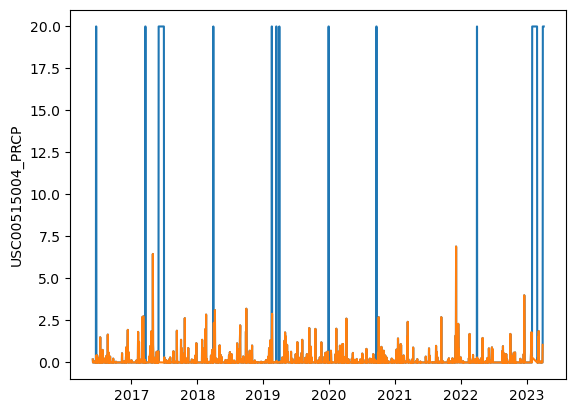

In [93]:
sns.lineplot(df_weather_features.iloc[:,5].fillna(20));
sns.lineplot(df_weather_features.iloc[:,5]);

In [94]:
list(df_weather_features.columns)

['US1HIMI0001_PRCP',
 'USC00515000_PRCP',
 'USC00515000_TMAX',
 'USC00515000_TMIN',
 'USC00515000_TOBS',
 'USC00515004_PRCP',
 'USC00515004_TMAX',
 'USC00515004_TMIN',
 'USC00515004_TOBS',
 'USC00515715_PRCP',
 'USC00518407_PRCP',
 'USC00518407_TMAX',
 'USC00518407_TMIN',
 'USW00022516_PRCP',
 'USW00022516_TMAX',
 'USW00022516_TMIN',
 'USW00022516_TAVG',
 'USW00022516_WSF2',
 'USW00022516_WSF5',
 'USW00022516_WDF2',
 'USW00022516_AWND',
 'USW00022516_WDF5',
 'USW00022516_WT01',
 'USW00022516_WT08',
 'USW00022516_WT03']

# Old work

In [ ]:

def geocode(address):
    params = { 'format'        :'json', 
               'addressdetails': 1, 
               'q'             : address}
    headers = { 'user-agent'   : 'TDI' }   #  Need to supply a user agent other than the default provided 
                                           #  by requests for the API to accept the query.
    return requests.get('http://nominatim.openstreetmap.org/search', 
                        params=params, headers=headers)

response = geocode('107 Page St., San Francisco')

In [ ]:
parser = configparser.ConfigParser()
_ = parser.read('snorkel.cfg')
ncei_auth_key = parser.get('NOAA_NCDC', 'token')

In [ ]:
base_url = "https://www.ncei.noaa.gov/cdo-web/api/v2/"


params = {
    'datasetid': 'GHCND',
    'startdate': '2016-06-04',
    'enddate': '2023-04-06',
    'units': 'metric',
    'limit': 25,
}
headers = {token: ncei_auth_key}

In [24]:

headers = {'token': ncei_auth_key}
params = {
    'dataset': 'daily-summaries',
    'boundingBox': [ 20.544036, -155.901725, 21.062098, -156.733017]
}
temp = requests.get('https://www.ncei.noaa.gov/access/services/data/v1',
                    params=params, headers=headers).json()

In [25]:
temp

{'errorCode': 400,
 'errorMessage': 'Bad Request',
 'errors': [{'field': 'stations',
   'message': 'A station is required.',
   'value': None},
  {'field': 'startDate',
   'message': 'A start date is required.',
   'value': None},
  {'field': 'endDate', 'message': 'An end date is required.', 'value': None}]}

In [62]:
## Get Maui weatherstations
headers = {'token': ncei_auth_key}
params = {
#    'dataset': 'daily-summaries',
#    'extent': (20.544036, -155.901725, 21.062098, -156.733017),
    'locationid': 'FIPS:15',
#    'locationcategoryid': 'ST',
    'startdate': '2016-06-04',
    'enddate': '2023-04-06',
    'limit': 400
}
stations = requests.get('https://www.ncei.noaa.gov/cdo-web/api/v2/stations/', params=params, headers=headers).json()

In [63]:
df_hi_stations = pd.json_normalize(stations['results'])
df_hi_stations['color'] = 'red'
df_hi_stations['marker'] = 'marker'
df_hi_stations[['latitude','longitude', 'color', 'marker', 'name']].to_csv('geoplotter_HI_stations.csv', index=False)
#df_hi_stations

In [82]:
df_maui_stations = df_hi_stations.loc[(df_hi_stations['latitude'] < 21.062098) & (df_hi_stations['latitude'] > 20.544036)
                  & (df_hi_stations['longitude'] < -155.901725) & (df_hi_stations['longitude'] > -156.733017)]
df_maui_stations[['latitude','longitude', 'color', 'marker', 'name']].to_csv('geoplotter_maui_stations.csv', index=False)

In [205]:
df_maui_stations

,elevation,mindate,maxdate,latitude,name,datacoverage,id,elevationUnit,longitude,color,marker
97,416.1,2012-10-01,2023-04-20,20.876061,"HAIKU 3.2 SE, HI US",0.8687,GHCND:US1HIMI0001,METERS,-156.304698,red,marker
117,106.7,2022-01-01,2023-03-03,20.928700,"HAIKU 488.7, HI US",1.0000,GHCND:USC00510822,METERS,-156.322100,red,marker
119,576.1,1905-01-01,2023-01-29,20.833300,"HALEAKALA RANCH 432, HI US",0.5633,GHCND:USC00510999,METERS,-156.316700,red,marker
120,2122.0,1939-03-01,2023-04-01,20.760300,"HALEAKALA RANGER STATION 338, HI US",0.9300,GHCND:USC00511004,METERS,-156.247000,red,marker
121,3037.0,1957-04-01,2023-04-17,20.716670,"HALEAKALA SUMMIT 338, HI US",0.2412,GHCND:USC00511008,METERS,-156.266670,red,marker
124,92.4,1942-01-01,2016-10-31,20.923300,"HAMAKUAPOKO 485, HI US",0.9885,GHCND:USC00511086,METERS,-156.340300,red,marker
125,22.9,1950-12-01,2023-04-20,20.794700,"HANA AIRPORT 355, HI US",0.7569,GHCND:USC00511125,METERS,-156.015400,red,marker
136,103.9,2006-01-01,2017-01-13,20.794000,"HONOMAELE 355.2, HI US",0.4456,GHCND:USC00511921,METERS,-156.041300,red,marker
140,335.3,1923-01-01,2023-04-17,20.954500,"KAHAKULOA 482.4, HI US",0.0947,GHCND:USC00512450,METERS,-156.534200,red,marker
144,213.4,1905-01-01,2022-11-30,20.890500,"KAILUA 446, HI US",0.8806,GHCND:USC00512679,METERS,-156.212700,red,marker


In [196]:
'&'.join(df_maui_stations['id'].tolist())

'GHCND:US1HIMI0001&GHCND:USC00510822&GHCND:USC00510999&GHCND:USC00511004&GHCND:USC00511008&GHCND:USC00511086&GHCND:USC00511125&GHCND:USC00511921&GHCND:USC00512450&GHCND:USC00512679&GHCND:USC00513317&GHCND:USC00513910&GHCND:USC00514489&GHCND:USC00514492&GHCND:USC00515000&GHCND:USC00515004&GHCND:USC00515178&GHCND:USC00515715&GHCND:USC00515720&GHCND:USC00515842&GHCND:USC00517000&GHCND:USC00517194&GHCND:USC00517566&GHCND:USC00518070&GHCND:USC00518219&GHCND:USC00518407&GHCND:USC00518543&GHCND:USC00518688&GHCND:USC00518744&GHCND:USC00518760&GHCND:USC00519275&GHCND:USC00519315&GHCND:USC00519376&GHCND:USC00519380&GHCND:USC00519494&GHCND:USC00519765&GHCND:USR0000HHAI&GHCND:USR0000HKAU&GHCND:USW00022516&WBAN:22516&WBAN:22552'

In [269]:
headers = {'token': ncei_auth_key}
params = {
    'datasetid': 'GHCND',
#    'locations': [ 20.544036, -155.901725, 21.062098, -156.733017]
    'locationid': 'FIPS:15',
#    'stationid': 'GHCND:US1HIMI0001',
    'startdate': '2016-06-04',
    'enddate': '2023-04-06',
#    'locationcategoryid': 'ST',
    'limit': 30
}
df_labels = pd.json_normalize(requests.get('https://www.ncei.noaa.gov/cdo-web/api/v2/datatypes/', params=params, headers=headers).json()['results'])

In [270]:
df_labels.to_csv('weather_labels.csv', index=False)

In [170]:
stations = [ station.split(':')[1] for station in maui_stations_ids ]
stations.pop()
stations.pop()

'22516'

In [172]:
','.join(stations)

'US1HIMI0001,USC00510822,USC00510999,USC00511004,USC00511008,USC00511086,USC00511125,USC00511921,USC00512450,USC00512679,USC00513317,USC00513910,USC00514489,USC00514492,USC00515000,USC00515004,USC00515178,USC00515715,USC00515720,USC00515842,USC00517000,USC00517194,USC00517566,USC00518070,USC00518219,USC00518407,USC00518543,USC00518688,USC00518744,USC00518760,USC00519275,USC00519315,USC00519376,USC00519380,USC00519494,USC00519765,USR0000HHAI,USR0000HKAU,USW00022516'

In [ ]:
headers = {'token': ncei_auth_key}
params = {
    'datasetid': 'GHCND',
#    'locations': [ 20.544036, -155.901725, 21.062098, -156.733017]
#    'locationid': 'ZIP:28801',
    'stationid': 'GHCND:USW00022516',
    'startdate': '2022-05-01',
    'enddate': '2022-05-31',
#    'locationcategoryid': 'ST',
    'limit': 40,
    'units': 'standard'
}
requests.get('https://www.ncei.noaa.gov/cdo-web/api/v2/data/', params=params, headers=headers).json()

Try NCEI data services


In [173]:
#headers = {'token': ncei_auth_key}
params = {
    'dataset': 'daily-summaries',
#    'bbox': '20.544036,-155.901725,21.062098,-156.733017',
#    'locationid': 'ZIP:28801',
    'stations': ','.join(stations),
    'startDate': '2016-06-01',
    'endDate': '2023-04-06',
#    'locationcategoryid': 'ST',
    'limit': 40,
    'format': 'json',
    'units': 'standard',
    'includeStationName': 'true',
}
temp = requests.get('https://www.ncei.noaa.gov/access/services/data/v1', params=params, headers=headers).json()

In [165]:
pd.json_normalize(temp).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2501 entries, 0 to 2500
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   WSF2     2498 non-null   object
 1   STATION  2501 non-null   object
 2   WSF5     2493 non-null   object
 3   PRCP     2494 non-null   object
 4   NAME     2501 non-null   object
 5   DATE     2501 non-null   object
 6   WDF2     2498 non-null   object
 7   AWND     2492 non-null   object
 8   WDF5     2493 non-null   object
 9   WT01     536 non-null    object
 10  TMAX     2488 non-null   object
 11  TAVG     2501 non-null   object
 12  TMIN     2488 non-null   object
 13  WT08     374 non-null    object
 14  PGTM     95 non-null     object
 15  WT03     8 non-null      object
dtypes: object(16)
memory usage: 312.8+ KB


In [176]:
df_weather = pd.json_normalize(temp)

In [182]:
with pd.option_context('display.max_columns', None):
    display(df_weather)

,DATE,STATION,PRCP,NAME,SNOW,DAPR,MDPR,TMAX,TMIN,TOBS,SX52,SN52,TAVG,WSF2,WSF5,WDF2,AWND,WDF5,WT01,WT08,PGTM,WT03
0,2016-06-01,US1HIMI0001,0.93,"HAIKU 3.2 SE, HI US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-06-02,US1HIMI0001,0.16,"HAIKU 3.2 SE, HI US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-06-03,US1HIMI0001,0.05,"HAIKU 3.2 SE, HI US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-06-04,US1HIMI0001,0.00,"HAIKU 3.2 SE, HI US",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-06-05,US1HIMI0001,0.00,"HAIKU 3.2 SE, HI US",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35621,2023-04-02,USW00022516,0.23,"KAHULUI AIRPORT, HI US",NaN,NaN,NaN,85,66,NaN,NaN,NaN,75,23.0,31.1,50,8.72,60,1,NaN,NaN,NaN
35622,2023-04-03,USW00022516,0.00,"KAHULUI AIRPORT, HI US",NaN,NaN,NaN,85,68,NaN,NaN,NaN,73,23.9,29.1,30,12.30,30,NaN,NaN,NaN,NaN
35623,2023-04-04,USW00022516,0.00,"KAHULUI AIRPORT, HI US",NaN,NaN,NaN,85,64,NaN,NaN,NaN,74,29.1,35.1,40,13.42,40,NaN,NaN,NaN,NaN
35624,2023-04-05,USW00022516,0.00,"KAHULUI AIRPORT, HI US",NaN,NaN,NaN,83,65,NaN,NaN,NaN,75,31.1,36.0,40,17.45,40,NaN,NaN,NaN,NaN


In [314]:
df_labels.loc[df_labels['id']=='MDPR']
#df_labels.columns
#df_weather.

,mindate,maxdate,name,datacoverage,id
2,1832-05-11,2023-04-22,Multiday precipitation total (use with DAPR an...,1.0,MDPR


In [335]:
pd.date_range('2016-06-01', '2023-04-06', freq='D')

DatetimeIndex(['2016-06-01', '2016-06-02', '2016-06-03', '2016-06-04',
               '2016-06-05', '2016-06-06', '2016-06-07', '2016-06-08',
               '2016-06-09', '2016-06-10',
               ...
               '2023-03-28', '2023-03-29', '2023-03-30', '2023-03-31',
               '2023-04-01', '2023-04-02', '2023-04-03', '2023-04-04',
               '2023-04-05', '2023-04-06'],
              dtype='datetime64[ns]', length=2501, freq='D')

In [350]:
"""
For each weather station, drop columns which have all na values, 
drop name, station columns, and rename columns to have station name in them. 
Then add them to the weather dataframe. 

index = pd.date_range('2016-06-01', '2023-04-06', freq='D')
"""
df_weather_cleaned = pd.DataFrame()

for station in stations:
    temp = df_weather.query("STATION == @station").dropna(axis=1, how='all')
    cols = temp.columns
    wt_cols = { str(col): 0 for col in cols if 'WT' in col }
    temp.fillna(wt_cols, inplace=True)
    temp.drop(['STATION','NAME'], axis=1, inplace=True)
    temp.set_index('DATE', inplace=True)
    temp.rename(lambda x: stations[-1] + '_' + x, axis='columns', inplace=True)
    temp.index.name = None
    df_weather_cleaned = pd.concat([df_weather_cleaned, temp], axis=1, join='outer')
#    print(df_weather_cleaned)
    
df_weather_cleaned.sort_index(inplace = True)

In [351]:
df_weather_cleaned.to_csv('df_weather_cleaned_maybe_needs_more.csv')

In [281]:
df_weather.query("STATION == @stations[-1]").dropna(axis=1, how='all')

,DATE,STATION,PRCP,NAME,TMAX,TMIN,TAVG,WSF2,WSF5,WDF2,AWND,WDF5,WT01,WT08,PGTM,WT03
33125,2016-06-01,USW00022516,0.01,"KAHULUI AIRPORT, HI US",84,70,74,21.0,25.1,40,10.29,40,1,NaN,NaN,NaN
33126,2016-06-02,USW00022516,0.00,"KAHULUI AIRPORT, HI US",82,71,75,21.9,23.9,40,9.84,30,1,1,NaN,NaN
33127,2016-06-03,USW00022516,0.00,"KAHULUI AIRPORT, HI US",85,68,76,16.1,21.0,10,8.95,360,NaN,NaN,NaN,NaN
33128,2016-06-04,USW00022516,0.00,"KAHULUI AIRPORT, HI US",84,68,75,14.1,19.9,20,5.59,30,1,NaN,NaN,NaN
33129,2016-06-05,USW00022516,0.00,"KAHULUI AIRPORT, HI US",85,68,77,18.1,23.0,30,8.28,20,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35621,2023-04-02,USW00022516,0.23,"KAHULUI AIRPORT, HI US",85,66,75,23.0,31.1,50,8.72,60,1,NaN,NaN,NaN
35622,2023-04-03,USW00022516,0.00,"KAHULUI AIRPORT, HI US",85,68,73,23.9,29.1,30,12.30,30,NaN,NaN,NaN,NaN
35623,2023-04-04,USW00022516,0.00,"KAHULUI AIRPORT, HI US",85,64,74,29.1,35.1,40,13.42,40,NaN,NaN,NaN,NaN
35624,2023-04-05,USW00022516,0.00,"KAHULUI AIRPORT, HI US",83,65,75,31.1,36.0,40,17.45,40,NaN,NaN,NaN,NaN


In [259]:
df_weather.query("STATION == @stations[-1] and WT03 == WT03")

,DATE,STATION,PRCP,NAME,SNOW,DAPR,MDPR,TMAX,TMIN,TOBS,...,TAVG,WSF2,WSF5,WDF2,AWND,WDF5,WT01,WT08,PGTM,WT03
33229,2016-09-13,USW00022516,0.23,"KAHULUI AIRPORT, HI US",NaN,NaN,NaN,86,75,NaN,...,79,21.0,25.1,50,10.51,50,1,NaN,NaN,1
33380,2017-02-11,USW00022516,1.21,"KAHULUI AIRPORT, HI US",NaN,NaN,NaN,77,68,NaN,...,74,40.9,48.1,210,18.34,210,1,1,NaN,1
33399,2017-03-02,USW00022516,0.09,"KAHULUI AIRPORT, HI US",NaN,NaN,NaN,82,70,NaN,...,71,25.1,32.0,210,13.42,220,NaN,NaN,NaN,1
33404,2017-03-07,USW00022516,1.51,"KAHULUI AIRPORT, HI US",NaN,NaN,NaN,81,64,NaN,...,75,15.0,21.0,10,7.16,20,1,NaN,NaN,1
33802,2018-04-09,USW00022516,0.16,"KAHULUI AIRPORT, HI US",NaN,NaN,NaN,77,68,NaN,...,73,23.0,27.1,30,16.55,30,1,1,NaN,1
33806,2018-04-13,USW00022516,0.00,"KAHULUI AIRPORT, HI US",NaN,NaN,NaN,87,64,NaN,...,76,25.1,32.0,40,10.96,40,NaN,NaN,NaN,1
34393,2019-11-21,USW00022516,0.02,"KAHULUI AIRPORT, HI US",NaN,NaN,NaN,85,71,NaN,...,79,29.1,35.1,30,16.33,60,1,NaN,NaN,1
35516,2022-12-18,USW00022516,1.87,"KAHULUI AIRPORT, HI US",NaN,NaN,NaN,74,67,NaN,...,73,25.9,36.0,180,11.41,170,1,NaN,NaN,1


In [212]:
def get_weather_data(stationid):
    params = {
    'dataset': 'daily-summaries',
    'stations': stationid,
    'startDate': '2016-06-01',
    'endDate': '2023-04-06',
    'format': 'json',
    'units': 'standard',
    'includeStationName': 'true',
    }
    response = requests.get('https://www.ncei.noaa.gov/access/services/data/v1', params=params)
    while response != 200:
        time.sleep(5)
        response = requests.get('https://www.ncei.noaa.gov/access/services/data/v1', params=params)
    return response.json()['results']

In [213]:
maui_weather_tables = []
for station in stations:
    maui_weather_tables.append(get_weather_data(station))

KeyboardInterrupt: 

In [ ]:
len(maui_weather_table)

In [1]:
stations

NameError: name 'stations' is not defined